# 艾里斑 分析
针对10um、20um 的针孔图像，裁剪出来，找到过中心的一条线，绘制光强变换曲线，确定艾里斑大小

# 结论
艾里斑的暗处实际上灰度值依旧很高，甚至

In [24]:
from scipy.ndimage import convolve

def find_closest_label(centroids, filtered_labels, image_center):
    min_distance = float('inf')
    closest_label = None

    for label in filtered_labels:
        centroid = centroids[label]
        distance = np.linalg.norm(np.array(image_center) - np.array(centroid))
        if distance < min_distance:
            min_distance = distance
            closest_label = label

    return closest_label

def find_max_laplacian_point(image):
    # 获取图像中心坐标
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

    # 定义要搜索的区域大小（以像素为单位）
    region_size = 20

    # 确保搜索区域不超出图像边界
    start_x = max(center_x - region_size // 2, 0)
    end_x = min(center_x + region_size // 2 + 1, image.shape[1])
    start_y = max(center_y - region_size // 2, 0)
    end_y = min(center_y + region_size // 2 + 1, image.shape[0])

    # 定义拉普拉斯算子
    laplacian_operator = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # 在指定区域内应用拉普拉斯算子
    laplacian_result = convolve(image[start_y:end_y, start_x:end_x], laplacian_operator, mode='constant', cval=0.0)

    # 获取绝对值最大值的坐标
    max_laplacian_coords = np.unravel_index(np.argmax(np.abs(laplacian_result)), laplacian_result.shape)

    # 转换为图像的绝对坐标
    max_laplacian_coords_absolute = (start_y + max_laplacian_coords[0], start_x + max_laplacian_coords[1])

    return max_laplacian_coords_absolute



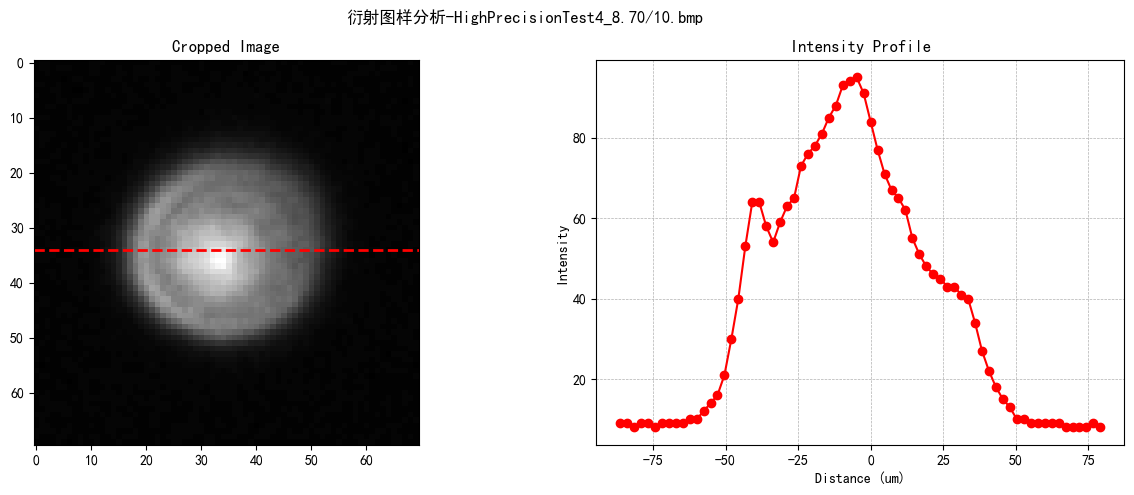

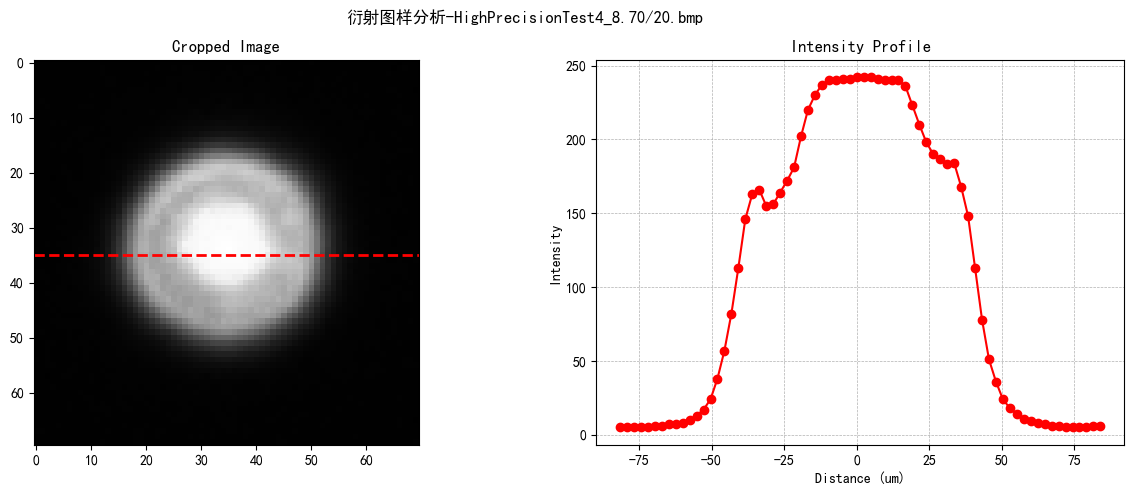

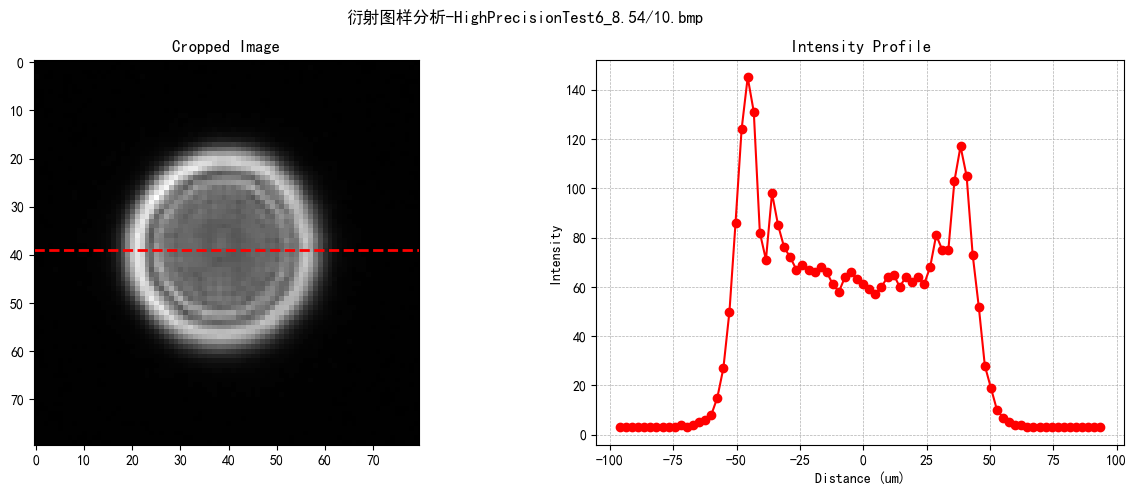

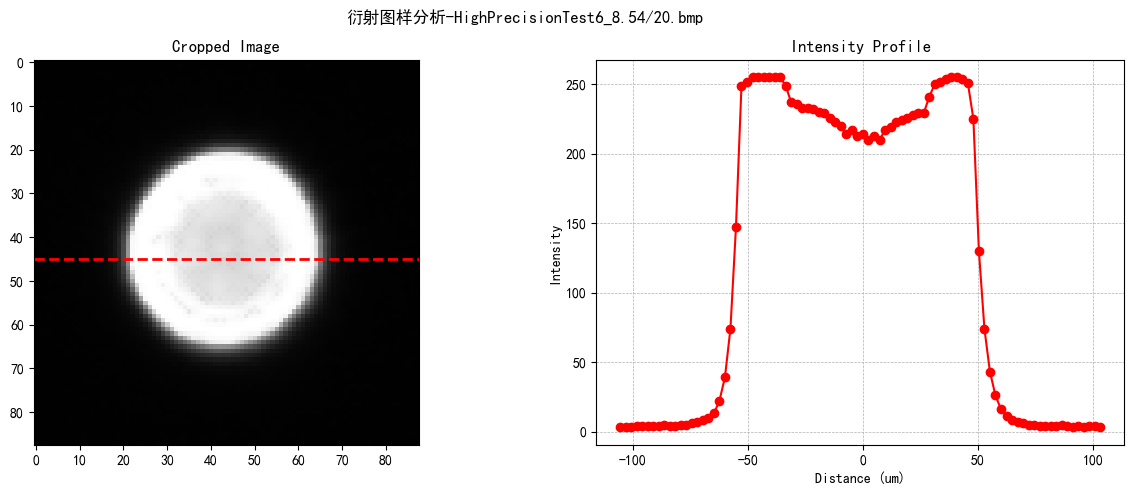

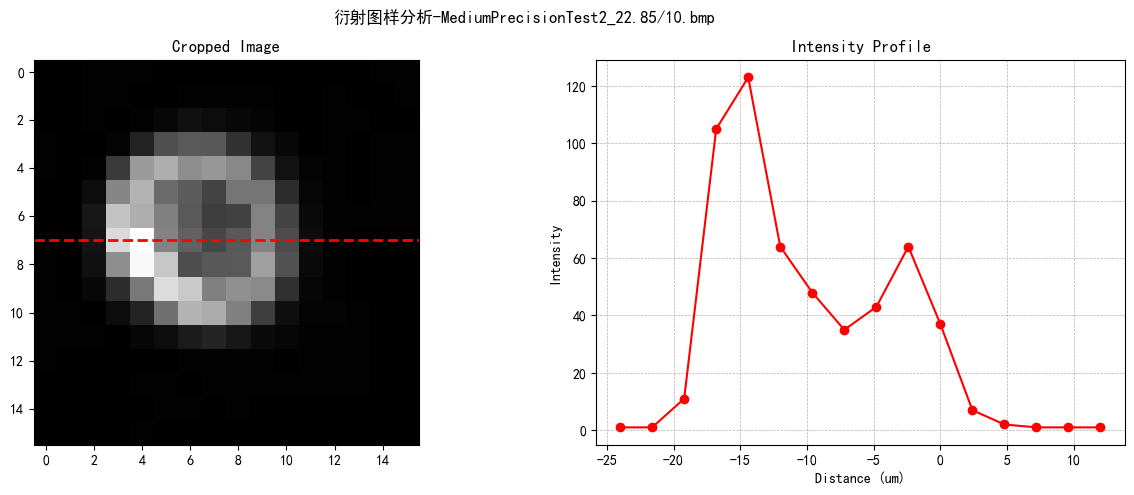

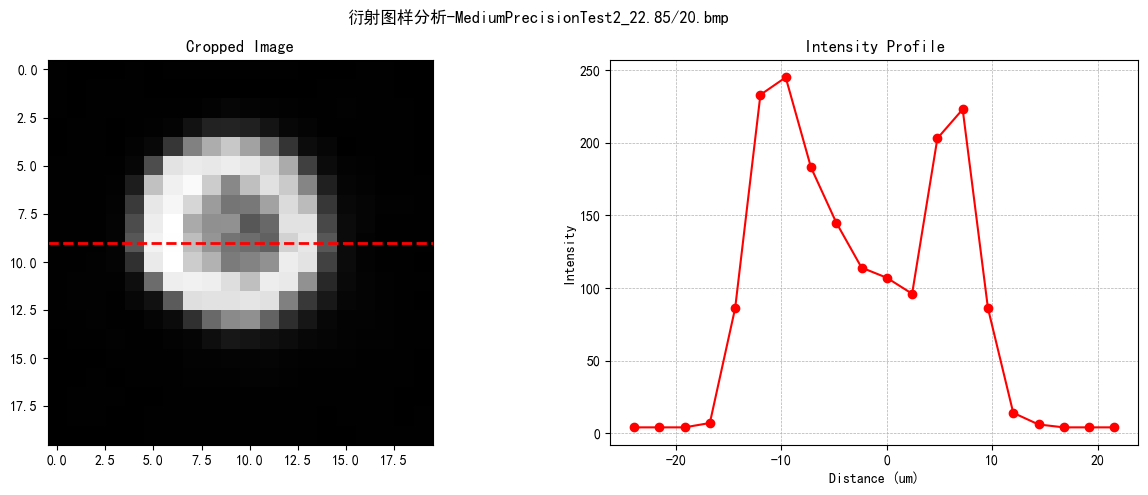

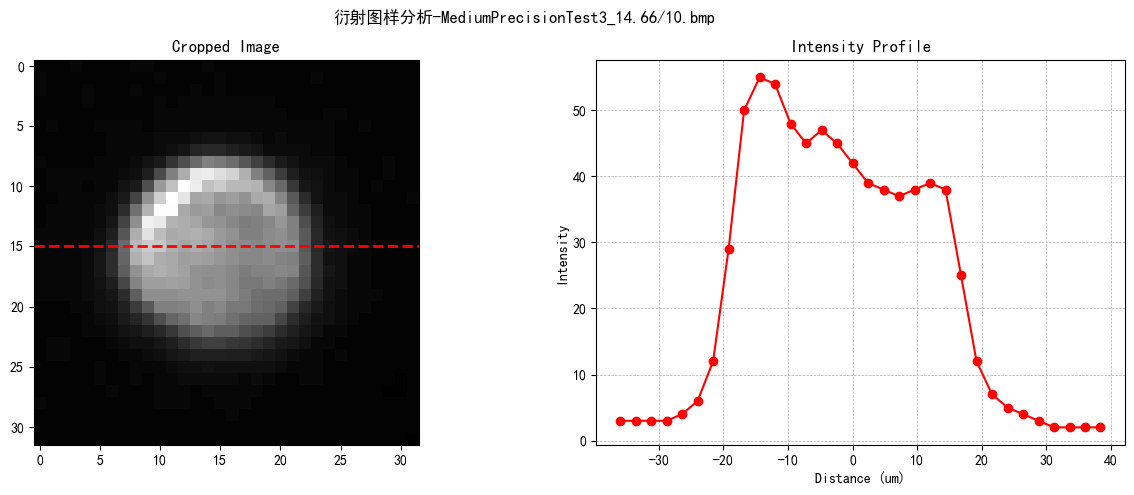

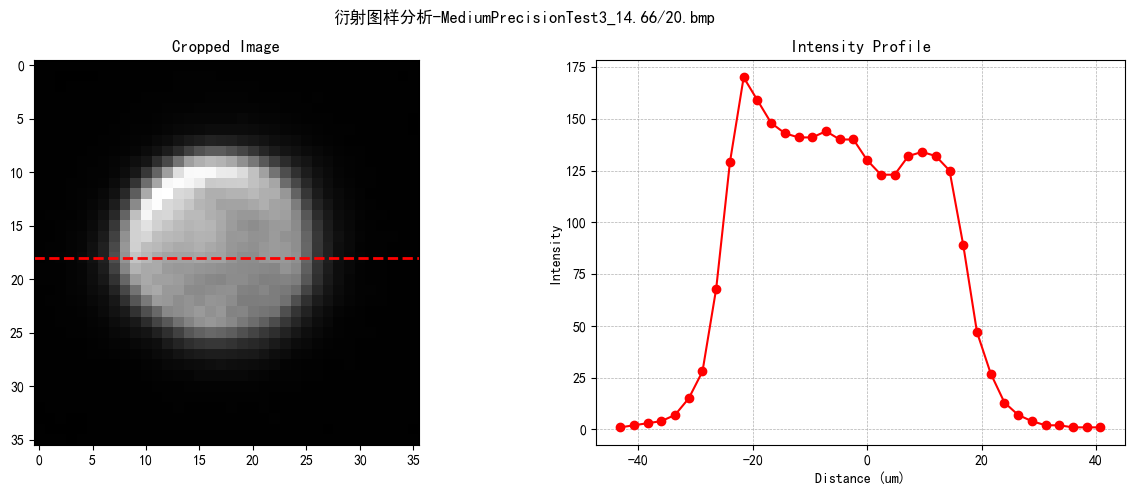

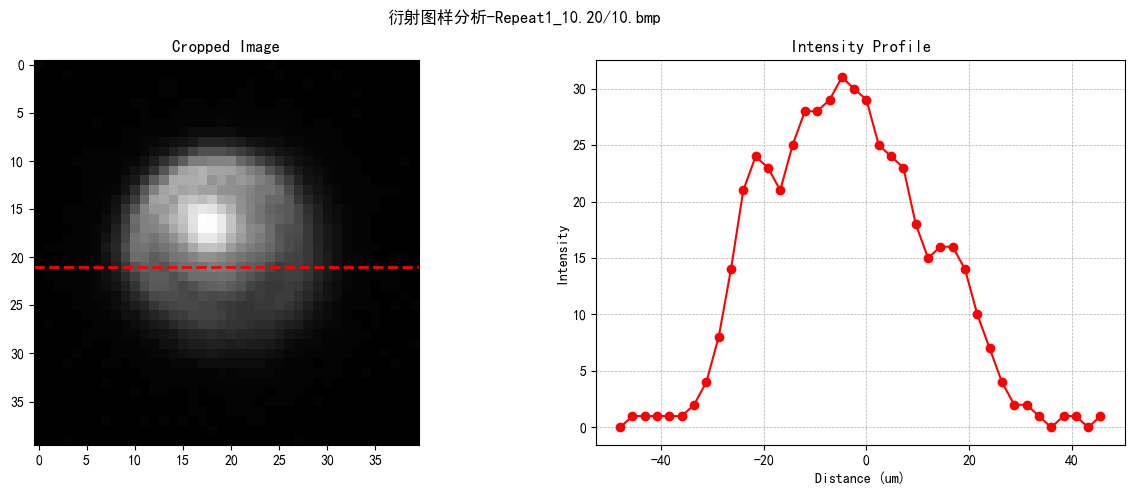

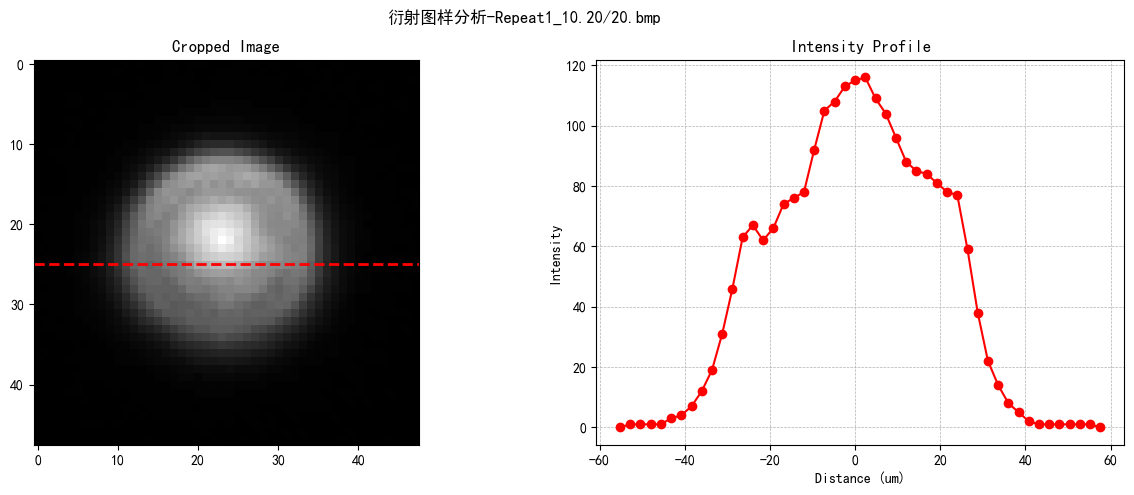

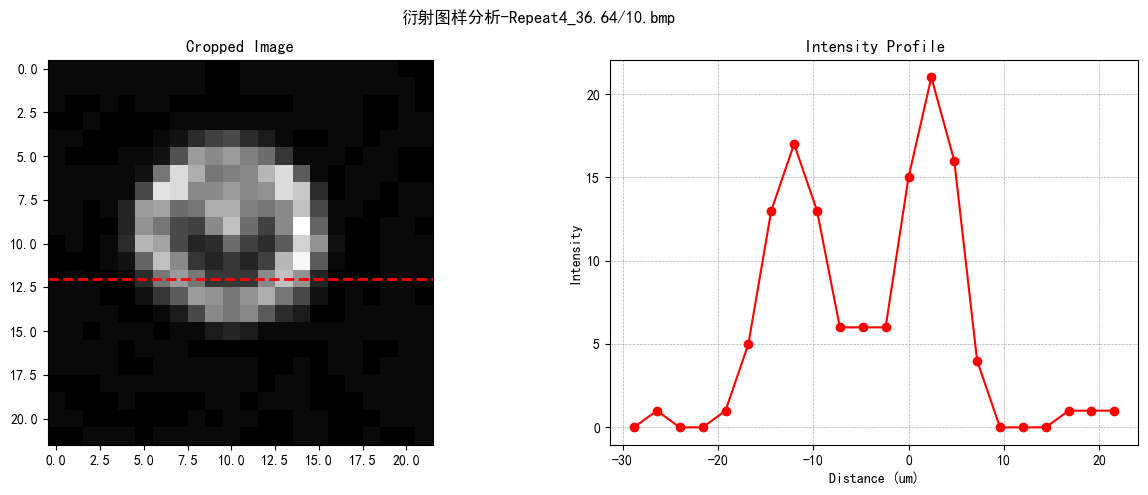

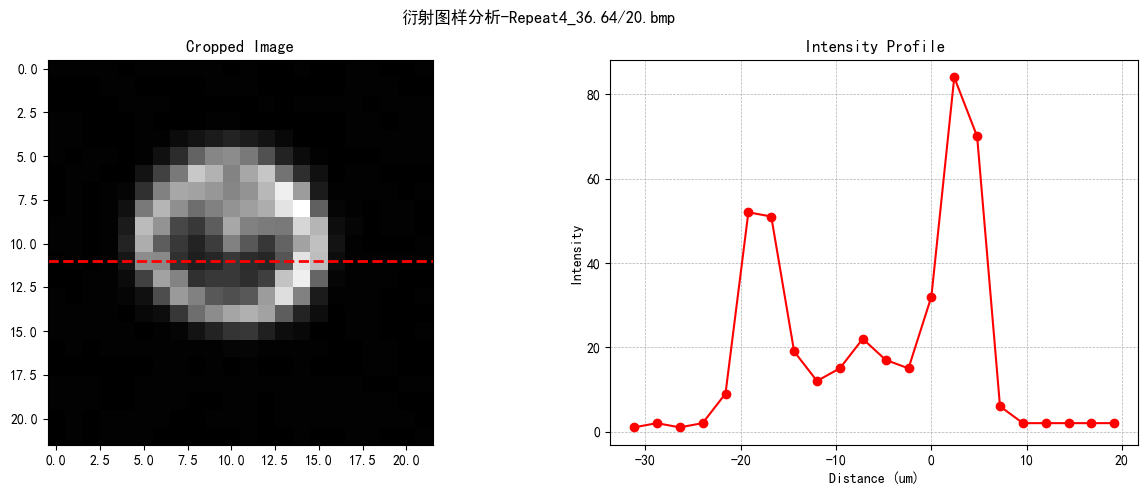

In [64]:
from mypackages.SingleExperimentAnalysis import SingleExperimentAnalysis
import math
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

from mypackages.gamma import gamma_correction
from mypackages.visualization3D import visualize_3d_array
from mypackages.config import *
import re
from PIL import Image, ImageDraw

# 找到区域，裁剪

title = "艾里斑分析"
dataset_path = 'Dataset/ZZMImgs'
# dirs = ['MediumPrecisionTest2_22.85']
dirs = ['HighPrecisionTest4_8.70','HighPrecisionTest6_8.54','MediumPrecisionTest2_22.85','MediumPrecisionTest3_14.66','Repeat1_10.20','Repeat4_36.64']
imgs = ['10','20']
for dir in dirs:
    true_area = []
    magnifications_1D = []
    for img in imgs:
        image_path = dataset_path+'/'+dir+'/'+img+'.bmp'
        precision  = 2.4 #像元尺寸2.4um   float(image_path.split('/')[-2].split('_')[-1])
        diameter   = float(re.search(r'(\d+)', image_path.split('/')[-1]).group())
        # 读取灰度图像
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 检查图像是否成功读取
        if image is None:
            print("Error: Could not read the image.")
            exit()
        # 局部阈值分割
        adaptive_threshold = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, -1)
        if DEBUG:
            plt.imshow(adaptive_threshold, cmap='gray'),plt.title('threshold'),plt.show()
            visualize_3d_array(adaptive_threshold,title="threshold")
        # 开运算 去除噪点
        # 闭运算 联通区域
        # 如果本来成像就小的话，应该采用最小的核
        radius = 1.5 if diameter > 20 else 0.5# 圆形的半径 过滤直径为6以下的圆形噪点
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2*radius+1), int(2*radius+1)))
        morphology_image = cv2.morphologyEx(adaptive_threshold, cv2.MORPH_OPEN, kernel)
        radius = 50 # 圆形的半径
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
        morphology_image = cv2.morphologyEx(morphology_image, cv2.MORPH_CLOSE, kernel)
        if DEBUG:
            plt.imshow(morphology_image, cmap='gray'),plt.title('threshold-morphology'),plt.show()
            visualize_3d_array(morphology_image,title="threshold-morphology")
        # 过滤不合理的区域
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(morphology_image, connectivity=8)
        # 过滤面积大于阈值的连通组件
        min_area_threshold = 5 # math.pow((322-2.2*diameter)/precision,2) * 0.03
        max_area_threshold = math.pow((322-2.2*diameter)/precision,2) * 20  # 此处使用了放大倍率和diameter之间的近似关系 mag = 322/diameter-2.2
        filtered_labels = [label for label, stat in enumerate(stats[1:], start=1) if  min_area_threshold < stat[4] < max_area_threshold]
        # 找到最近的连通域
        image_center = [image.shape[1]//2,image.shape[0]//2]
        closest_label = find_closest_label(centroids, filtered_labels, image_center)
        # 获取连通域的坐标信息
        x, y, width, height = stats[closest_label][0:4]
        # 计算裁剪图片的中心点坐标
        crop_center = (x + width // 2, y + height // 2)
        # 以长度是连通域长度的2倍的正方形裁剪处理
        crop_size = 2 * max(width, height)
        # 计算裁剪区域的左上角坐标
        crop_x = crop_center[0] - crop_size // 2
        crop_y = crop_center[1] - crop_size // 2
        # 裁剪图像
        cropped_image = image[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
        # 保存裁剪后的图像
        cropped_filename = "Cropped_" + os.path.basename(image_path).split('.')[0] + ".bmp"
        output_path = os.path.join(os.path.dirname(image_path), cropped_filename)
        cv2.imwrite(output_path, cropped_image)
        # 找到灰度最大的中心点
        max_intensity_point = find_max_laplacian_point(cropped_image)
        # 转换坐标
        x_values_um = (np.arange(cropped_image.shape[1]) -  max_intensity_point[1]) * precision
        y_values = cropped_image[max_intensity_point[0], :]
        plt.figure(figsize=(15,5))
        # 左侧子图 - 显示 cropped_image
        plt.subplot(1, 2, 1)
        plt.imshow(cropped_image, cmap='gray', origin='upper')
        plt.axhline(max_intensity_point[0], color='red', linestyle='--', linewidth=2)
        plt.title('Cropped Image')
        # 右侧子图 - 显示原始像素灰度值的曲线
        plt.subplot(1, 2, 2)
        plt.plot(x_values_um, y_values, color='red', marker='o')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlabel("Distance (um)")
        plt.ylabel("Intensity")
        plt.title("Intensity Profile")
        Profile_filename = "Intensity Profile_" + os.path.basename(image_path).split('.')[0] + ".png"
        output_path = os.path.join(os.path.dirname(image_path), Profile_filename)
        plt.savefig(output_path, dpi=800)
        plt.suptitle('衍射图样分析-'+dir+'/'+img+'.bmp')
        # plt.show()
 

(1500,800)(4000,1100)
Cropped image saved at: Dataset/ZZMImgs/LowPrecisionTest1_74.24/origin/Image_20231107181437558_10_Cropped.bmp
(1500,1200)(4000,1500)
Cropped image saved at: Dataset/ZZMImgs/LowPrecisionTest1_74.24/origin/Image_20231107181437558_20_Cropped.bmp
(1500,1600)(4000,1900)
Cropped image saved at: Dataset/ZZMImgs/LowPrecisionTest1_74.24/origin/Image_20231107181437558_50_Cropped.bmp
(1500,2000)(4000,2300)
Cropped image saved at: Dataset/ZZMImgs/LowPrecisionTest1_74.24/origin/Image_20231107181437558_100_Cropped.bmp
